In [1]:
# Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sps
from sklearn.manifold import Isomap, MDS

### Preprocessing the data

In [10]:
# Importing the data into pandas dataframe
df = pd.read_csv('zoo.csv')
df = df.transpose()

# Removing 'animal name' and 'type' since not used for PCA 
preprocessed_dataframe = df.drop(axis = 0, index = ['animal name', 'type'])
df = df.transpose()
# In data_matrix:
# Columns: Data points
# Rows: Attributes
data_matrix = preprocessed_dataframe.to_numpy(dtype=float)
df

#Should we do this? Makes the separation greater..
data_matrix[data_matrix==0] = -1


### Implementation of PCA

In [11]:

def PCA(data_matrix):
    # Centering the data for PCA
    centered_data_matrix = data_matrix - np.reshape(np.mean(data_matrix, axis = 1), (16,1))

    [U,S,V] = np.linalg.svd(centered_data_matrix)
    W = U[:,0:2]

    # In latent_matrix:
    # Columns: Data points
    # Rows: Attributes
    latent_data_matrix = np.tensordot(W.T, centered_data_matrix, axes = 1)
    
    return latent_data_matrix



### Implementation of MDS

In [4]:
def weighted_distance(a,b, weight_vector = np.ones(16)):
    #TODO: Add input for attribute w
    attribute_weight_matrix = np.diag(weight_vector)
    attribute_weight_matrix[7,7] = 1
    weighted_difference = np.matmul(attribute_weight_matrix, a-b)

    return np.linalg.norm(weighted_difference)

def to_dist_matrix(data_matrix, weight_vector):
    distance_matrix = np.array([[weighted_distance(a, b, weight_vector) for a in data_matrix.T] for b in data_matrix.T])
    
    return distance_matrix

def dist_to_similarity_matrix(K):
    
    # Transforming it to a similarity matrix
    n = K.shape[1]
    sum_matrix = np.ones((n,n))
    mean_rows = np.matmul(K,sum_matrix)/n
    mean_columns = np.matmul(sum_matrix, K)/n
    variance = np.matmul(sum_matrix, mean_rows)/n

    similarity_matrix = -0.5*(K - mean_rows - mean_columns + variance)

    return similarity_matrix

def MDS(similarity_matrix, n_latent_variables):
    
    # Checking that the matrix is symmetric
    #print(np.allclose(similarity_matrix, similarity_matrix.T, rtol=1e-05, atol=1e-08))
    [D,Q] = np.linalg.eig(similarity_matrix)
    
    # Ensuring that the eigenvalues are real
    D = np.real(D)
    Q = np.real(Q)
    
    # Sorting the eigenpairs after magnitude of eigenvalues
    order = np.flip(np.argsort(D))
    D = D[order]
    Q = Q[:,order]
    D = np.diag(D)
    
    # Finding the latent variables
    latent_data_matrix = np.matmul(np.sqrt(D[:n_latent_variables,:]), Q.T)
    
    return latent_data_matrix



In [5]:
# Using the properties of SVD to calculate the MDS
[U,S,V] = np.linalg.svd(data_matrix)

# Creating the tall singular value matrix
sigma = np.zeros((16,101))
np.fill_diagonal(sigma, S)

# In latent_matrix:
# Columns: Data points
# Rows: Attributes
latent_matrix_MDS_SVD = np.tensordot(sigma, V, axes=1)

### Implementation of Isomap

In [6]:
def to_graph_matrix(data_matrix, k_neighbours, weight_vector):
    """
    Computing the graph matrix of the data, connecting the k closest points
    :param data_matrix: Matrix of size (m,n) with data points as columns and attributes as rows
    :param k_neighbours: Number of connected neighbours in the resulting graph
    :return: graph matrix of size (n,n)
    """
    graph_matrix = to_dist_matrix(data_matrix, weight_vector)
    
    # Marking neighbours further away than "k_neighbours" as unobtainable
    neighbour_order = np.argsort(graph_matrix, axis=1)
    graph_matrix[neighbour_order > k_neighbours] = 0

    return graph_matrix

def isomap(data_matrix, k, n_latent_variables, weight_vector):
    
    graph_matrix = to_graph_matrix(data_matrix, k, weight_vector)
    shortest_path_matrix = sps.csgraph.shortest_path(graph_matrix, directed=False)
    similarity_matrix = dist_to_similarity_matrix(shortest_path_matrix)
    
    latent_data_matrix = MDS(similarity_matrix, n_latent_variables)

    return latent_data_matrix



### Running the Implementations

In [26]:
weight_vector = np.ones(16)
weight_vector[12] = 1
df.describe
#PCA
latent_data_matrix_PCA = PCA(data_matrix)
# Adding the latent variables to the original dataframe
df['x1_PCA'] = latent_data_matrix_PCA[0,:].T
df['x2_PCA'] = latent_data_matrix_PCA[1,:].T

# MDS
similarity_matrix = dist_to_similarity_matrix(to_dist_matrix(data_matrix, weight_vector))
latent_data_matrix_MDS = MDS(similarity_matrix, 2)
# Adding the latent variables to the original dataframe
df['x1_MDS'] = latent_data_matrix_MDS[0,:]
df['x2_MDS'] = latent_data_matrix_MDS[1,:]

# Isomap
number_of_neighbours = 101
latent_data_matrix_isomap = isomap(data_matrix, number_of_neighbours, 2, weight_vector)
# Adding the latent variables to the original dataframe
df['x1_isomap'] = latent_data_matrix_isomap[0,:]
df['x2_isomap'] = latent_data_matrix_isomap[1,:]

# qqq: Ska isomap och MDS bli samma när man kör att alla är grannar?

### Plotting the results

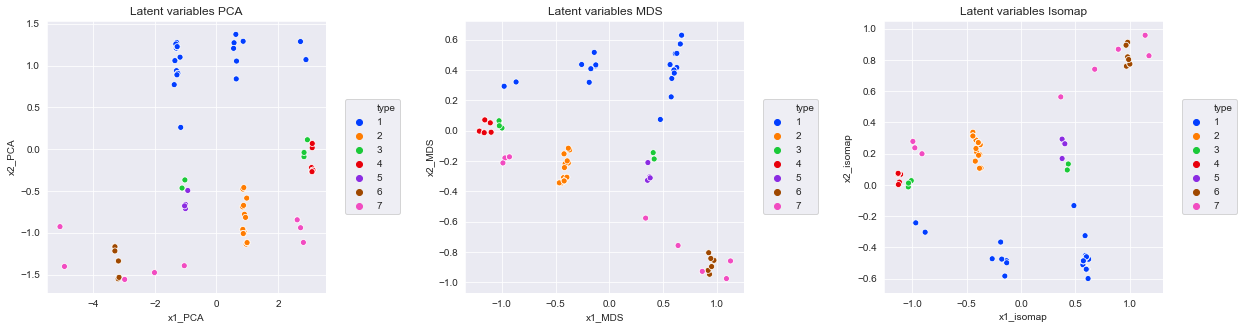

In [27]:
x1 = ['x1_PCA', 'x1_MDS', 'x1_isomap']
x2 = ['x2_PCA', 'x2_MDS', 'x2_isomap']
title = ['Latent variables PCA', 'Latent variables MDS', 'Latent variables Isomap']



fig, axes = plt.subplots(1, 3, figsize=(20, 5))
plt.subplots_adjust(wspace=0.5)
for i in range(3):
    ax = sns.scatterplot(ax=axes[i], x=x1[i], y=x2[i], hue='type', data=df, palette='bright')
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5), ncol=1)
    axes[i].set_title(title[i])
    sns.set_style('darkgrid')
plt.show()

In [28]:
# TODO: Check centering of distance matrix 
df

,animal name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,tail,domestic,catsize,type,x1_PCA,x2_PCA,x1_MDS,x2_MDS,x1_isomap,x2_isomap
0,aardvark,1,0,0,1,0,0,1,1,1,...,0,0,1,1,-1.351029,1.058533,0.626890,0.416312,0.621518,-0.475485
1,antelope,1,0,0,1,0,0,0,1,1,...,1,0,1,1,-1.306634,1.208344,0.659495,0.571450,0.605808,-0.537966
2,bass,0,0,1,0,0,1,1,1,1,...,1,0,0,4,3.131655,-0.252200,-1.207572,-0.003554,-1.133287,0.069237
3,bear,1,0,0,1,0,0,1,1,1,...,0,0,1,1,-1.351029,1.058533,0.626890,0.416312,0.621518,-0.475485
4,boar,1,0,0,1,0,0,1,1,1,...,1,0,1,1,-1.277296,1.225750,0.671441,0.629426,0.573141,-0.485703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,wallaby,1,0,0,1,0,0,0,1,1,...,1,0,1,1,0.628988,1.372461,-0.140380,0.516119,-0.149640,-0.583054
97,wasp,1,0,1,0,1,0,0,0,0,...,0,0,0,6,-3.300783,-1.217590,0.942901,-0.843431,0.989811,0.802144
98,wolf,1,0,0,1,0,0,1,1,1,...,1,0,1,1,-1.277296,1.225750,0.671441,0.629426,0.573141,-0.485703
99,worm,0,0,1,0,0,0,0,0,0,...,0,0,0,7,2.621602,-0.845385,-0.928552,-0.173131,-0.911749,0.199206
